# BETH Dataset EDA, Preperation and Model Training

>The BETH dataset currently represents 8,004,918 events collected over 23 honeypots, running for about five noncontiguous hours on a major cloud provider. For benchmarking and discussion, we selected the initial subset of the process logs. This subset was further divided into training, validation, and testing sets with a rough 60/20/20 split based on host, quantity of logs generated, and the activity logged—only the test set includes an attack
>
>The dataset is composed of two sensor logs: kernel-level process calls and network traffic. The initial benchmark subset only includes process logs. Each process call consists of 14 raw features and 2 hand-crafted labels.

This notebook is focused solely on the the process call data.

In [1]:
pip install --upgrade scikit-learn==1.0 --quiet

Note: you may need to restart the kernel to use updated packages.


'c:\Users\Fabio' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # viz
import matplotlib.pyplot as plt # viz
from scipy import stats
import json
from typing import List, Tuple

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn import metrics, linear_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

c:\Users\Fabio e Ricardo\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initial Explore
## Load Data

In [5]:
train_df = pd.read_csv('labelled_training_data.csv')
test_df = pd.read_csv('labelled_testing_data.csv')
validation_df = pd.read_csv('labelled_validation_data.csv')

## Check all of the columns are the same across all three dataframes

In [6]:
assert train_df.columns.all() == test_df.columns.all() == validation_df.columns.all()

In [7]:
train_df.dtypes

timestamp          float64
processId            int64
threadId             int64
parentProcessId      int64
userId               int64
mountNamespace       int64
processName         object
hostName            object
eventId              int64
eventName           object
stackAddresses      object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object

## Visual Inspection / Summary

In [8]:
train_df.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [7]:
train_df.describe(include=['object', 'float', 'int'])

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
count,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,7.631440e+05,763144,763144,763144.000000,763144,763144,763144.000000,763144.000000,763144,763144.000000,763144.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,36,8,NaN,32,97050,NaN,NaN,214720,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,ps,ubuntu,NaN,close,[],NaN,NaN,"[{'name': 'fd', 'type': 'int', 'value': 9}]",NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,406313,190500,NaN,218080,521115,NaN,NaN,107321,NaN,NaN
mean,1844.582673,6814.763308,6820.265241,1882.216609,2.279034,4.026532e+09,NaN,NaN,288.158953,NaN,NaN,2.672082,17.520924,NaN,0.001663,0.0
std,1136.638249,1948.871187,1937.068333,2215.563094,37.416576,1.649030e+02,NaN,NaN,385.117778,NaN,NaN,1.340906,318.596662,NaN,0.040744,0.0
min,132.560721,1.000000,1.000000,0.000000,0.000000,4.026532e+09,NaN,NaN,3.000000,NaN,NaN,0.000000,-115.000000,NaN,0.000000,0.0
25%,903.250802,7313.000000,7313.000000,187.000000,0.000000,4.026532e+09,NaN,NaN,3.000000,NaN,NaN,1.000000,0.000000,NaN,0.000000,0.0
50%,1829.203642,7365.000000,7365.000000,1385.000000,0.000000,4.026532e+09,NaN,NaN,62.000000,NaN,NaN,3.000000,0.000000,NaN,0.000000,0.0
75%,2761.380825,7415.000000,7415.000000,1648.000000,0.000000,4.026532e+09,NaN,NaN,257.000000,NaN,NaN,4.000000,4.000000,NaN,0.000000,0.0


From visual inspection of the output of `.head()` and `.describe()`, there are several interesting things can be spotted.

* The `timestamp` field is a bit funky and does not conform to the typical unix or ISO formats. From reading the paper, this is actually the time since last reboot. This fact makes the values for`std`, `min`, `25%`, `50%`, `75%` and `max` make much more sense.
* The `mountNamepsace` field looks like the vast majority of the values are the same and could warrant further investigation to see if it could be removed.
* The `processName` field has 36 unique values but the vast majority of them (approximately 60%) are related to the `ps` process.
* The `hostName` field has 8 unique values with a smaller, but still significant amount of them being`ubuntu`. This probably warrants a bit of a deeper look to see what this means for the other `hostname` values and if the `ps` process events are linked to this in anyway.
* The `eventName` field has 32 unique values with again a significant amount of them being `close`. This too probably warrants a bit more investigation to see what the distrubiton is across different values.
* The `stackAddresses` field is typically blank. The value of these values is not initial clear but could be used to determine stack size maybe.
* The `argsNum` and `args` fields seem coupled but it's currently unclear what these actually mean. The `args` field in particular seems to typically contain a `list` of values which could be extracted.
* The `sus` and `evil` fields are essentially the labels.
    >Logs marked suspicious indicate
unusual activity or outliers in the data distribution, such as
an external userId with a systemd process3
, infrequent
daemon process calls (e.g., “acpid” or “accounts-daemon”),
or calls to close processes that we did not observe as being
started. Evil
indicates a malicious external presence not
inherent to the system, such as a bash execution call to list
the computer’s memory information, remove other users’
ssh access, or un-tar an added file.

# EDA
## What are the `evil` and `sus` counts across the `train`, `test` and `validation`?

### `train` Dataset

<AxesSubplot:title={'center':'Labels Frequency for evil label in Train Dataset'}>

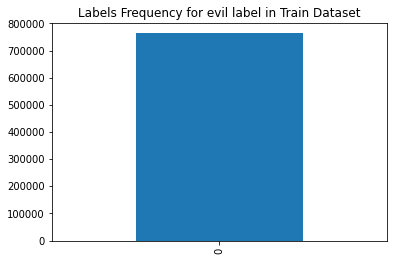

In [51]:
train_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Train Dataset')

<AxesSubplot:title={'center':'Label Frequency for sus label in Train Dataset'}>

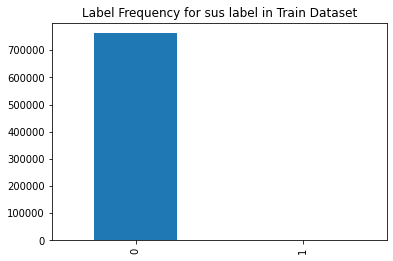

In [10]:
train_df.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Train Dataset')

### `test` Dataset

<AxesSubplot:title={'center':'Label Frequency for evil label in Test Dataset'}>

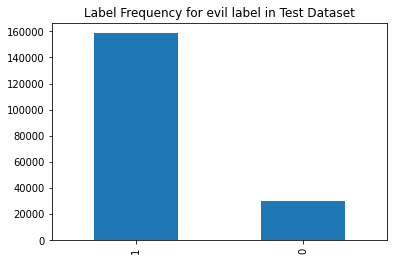

In [11]:
test_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Test Dataset')

<AxesSubplot:title={'center':'Label Frequency for sus label in Test Dataset'}>

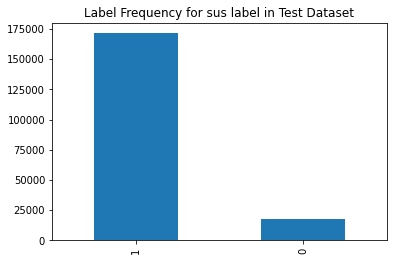

In [12]:
test_df.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Test Dataset')

### `validation` dataset

<AxesSubplot:title={'center':'Label Frequency for evil label in Validation Dataset'}>

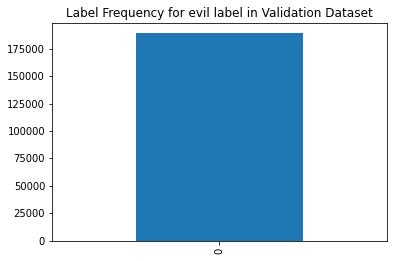

In [13]:
validation_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Validation Dataset')

<AxesSubplot:title={'center':'Label Frequency for sus label in Validation Dataset'}>

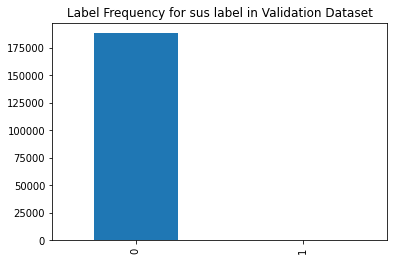

In [14]:
validation_df.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Validation Dataset')

## Are any events labelled both`sus` and `evil` in each dataset?

### `train` dataset

In [15]:
train_df.groupby(['sus', 'evil'])[['timestamp']].count()

,,timestamp
sus,evil,
0,0,761875
1,0,1269


<AxesSubplot:xlabel='sus,evil'>

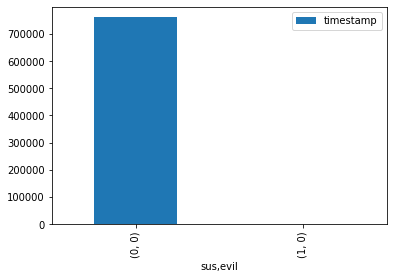

In [16]:
train_df.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

### `test` dataset

In [17]:
test_df.groupby(['sus', 'evil'])[['timestamp']].count()

timestamp
sus evil           
0   0         17508
1   0         13027
    1        158432

*Note: The snippet below is to double-check the results from the cell above.*

In [18]:
test_df.loc[(test_df['sus'] == 1) & (test_df['evil'] == 1)].shape[0]

158432

<AxesSubplot:xlabel='sus,evil'>

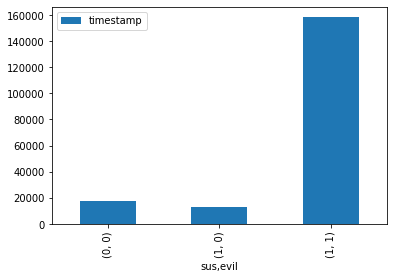

In [19]:
test_df.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

### `validation` dataset

In [20]:
validation_df.groupby(['sus', 'evil'])[['timestamp']].count()

,,timestamp
sus,evil,
0,0,188181
1,0,786


<AxesSubplot:xlabel='sus,evil'>

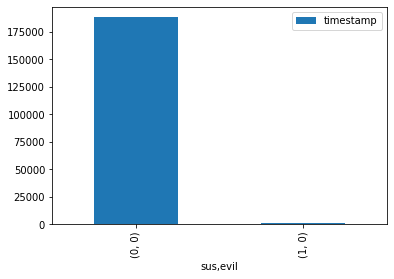

In [21]:
validation_df.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

**NOTE:** From looking at these plots, it looks fairly imbalanced across the board but this is expected with a dataset like this. From reading the paper, it's kinda' the whole point! The test dataset is the only dataset that contains `evil` labelled events. This means that anomoly detection approaches will probably the best place to start. Something like an Auto-Encoder or One-Class SVM.

## What is the correlation of features across each dataset?

In [22]:
def dataset_to_corr_heatmap(dataframe, title, ax):
    corr = dataframe.corr()
    sns.heatmap(corr, ax = ax, annot=True, cmap="YlGnBu")
    ax.set_title(f'Correlation Plot for {title}')

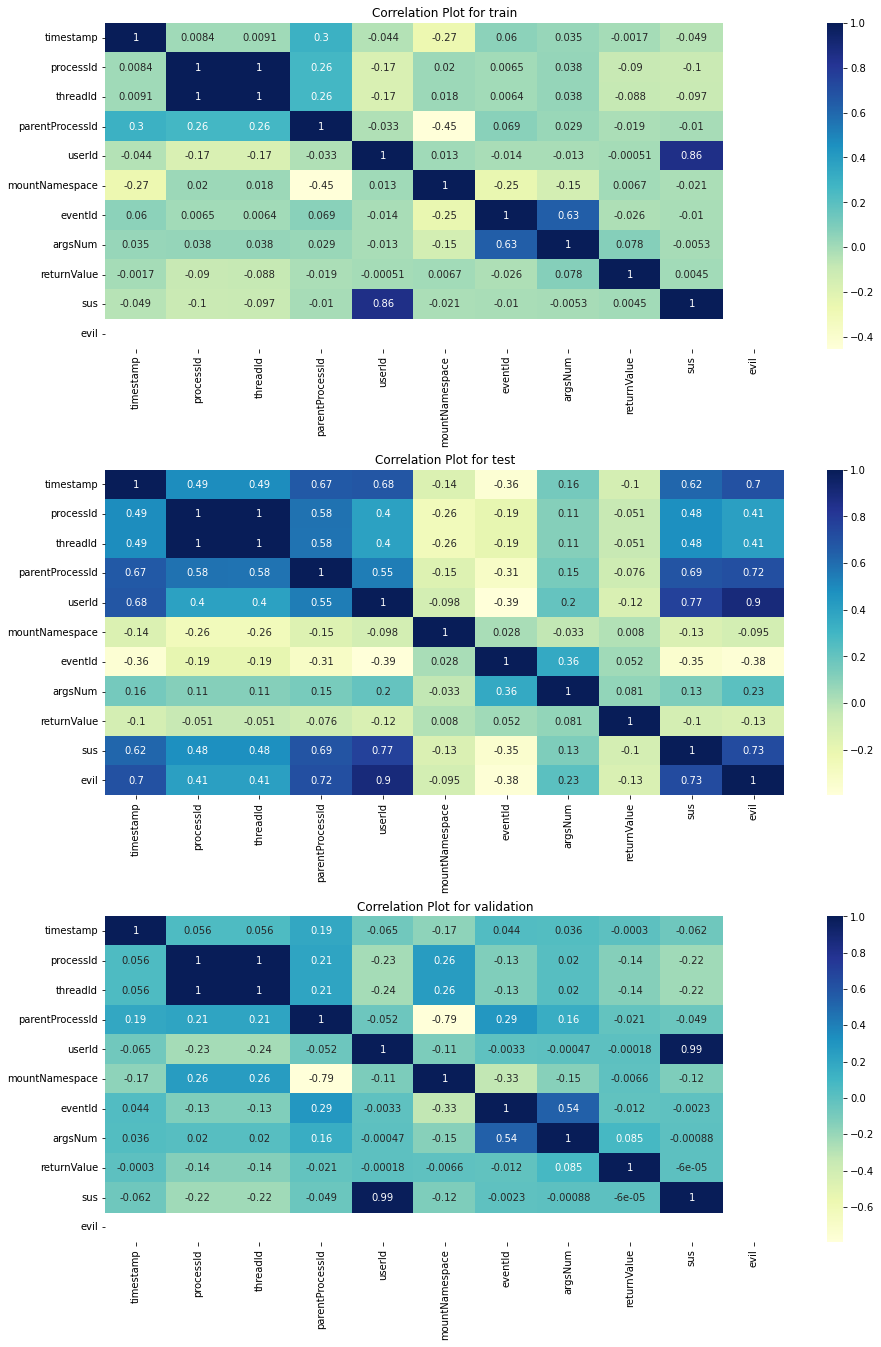

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,20))
fig.tight_layout(pad=10.0)
datasets = [train_df, test_df, validation_df]
dataset_names = ['train', 'test', 'validation']
axs = [ax1, ax2, ax3]

for dataset, name, ax in zip(datasets, dataset_names, axs):
    dataset_to_corr_heatmap(dataset, name, ax)

## What does this show?

* All three of the datasets have a heavy correlation between `userid` and the associated labels which feature in the dataset (`sus` and/or `evil`).
* `processid` and `threadid` are highly correlated and seem to have similar correlation vaules across all three datasets. This means that they are representing pretty much the same thing and one of them could be dropped.
* The correlation plots all look significantly different. This probably means its a hard problem!

## Experimenting with ways to compare the datasets

### Entropy

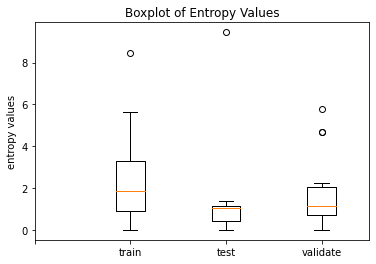

In [24]:
datasets = [train_df, test_df, validation_df]

entropy_values = []
for dataset in datasets:
    dataset_entropy_values = []
    for col in dataset.columns:
        if col == 'timestamp':
            pass
        else:
            counts = dataset[col].value_counts()
            col_entropy = stats.entropy(counts)
            dataset_entropy_values.append(col_entropy)
            
    entropy_values.append(dataset_entropy_values)

plt.boxplot(entropy_values)
plt.title('Boxplot of Entropy Values')
plt.ylabel("entropy values")
plt.xticks([0,1,2,3],labels=['','train', 'test', 'validate'])
plt.show()

### Variation

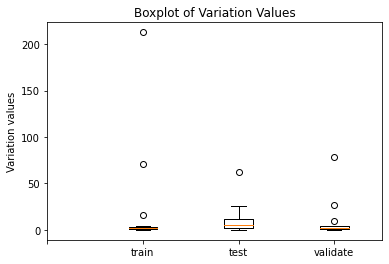

In [25]:
datasets = [train_df, test_df, validation_df]

variation_values = []
for dataset in datasets:
    dataset_variation_values = []
    for col in dataset.columns:
        if col == 'timestamp':
            pass
        else:
            counts = dataset[col].value_counts()
            col_variation = stats.variation(counts)
            dataset_variation_values.append(col_variation)
            
    variation_values.append(dataset_variation_values)

plt.boxplot(variation_values)
plt.title('Boxplot of Variation Values')
plt.ylabel("Variation values")
plt.xticks([0,1,2,3],labels=['','train', 'test', 'validate'])
plt.show()

## Exploring the Non-Numeric Cols

Let's use the `train_df` for this exploration

From looking at the annex of the paper related to this dataset, the `eventName` columns maps directly to the `eventId` column as shown in the cell below, becuase of this, it'll be ignored in the analysis. (Look at line 2 (idx 1) and line 8 (idx 7))

In [26]:
train_df.loc[:, ['eventId', 'eventName']].head(10)

,eventId,eventName
0,157,prctl
1,3,close
2,1010,sched_process_exit
3,21,access
4,1005,security_file_open
5,257,openat
6,5,fstat
7,3,close
8,1005,security_file_open
9,257,openat


In [27]:
train_df.loc[:, ['processName', 'hostName', 'args']].head(10)

,processName,hostName,args
0,close,ip-10-100-1-120,"[{'name': 'option', 'type': 'int', 'value': 'P..."
1,close,ip-10-100-1-120,"[{'name': 'fd', 'type': 'int', 'value': 19}]"
2,close,ip-10-100-1-120,[]
3,sh,ip-10-100-1-120,"[{'name': 'pathname', 'type': 'const char*', '..."
4,sh,ip-10-100-1-120,"[{'name': 'pathname', 'type': 'const char*', '..."
5,sh,ip-10-100-1-120,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."
6,sh,ip-10-100-1-120,"[{'name': 'fd', 'type': 'int', 'value': 3}, {'..."
7,sh,ip-10-100-1-120,"[{'name': 'fd', 'type': 'int', 'value': 3}]"
8,sh,ip-10-100-1-120,"[{'name': 'pathname', 'type': 'const char*', '..."
9,sh,ip-10-100-1-120,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."


## Check Unique Values for all three of the fields above

In [28]:
def column_uniques(df, col):
    print(f'{col} - Uniques:\n\n{df[col].unique()} \n\nNo. Uniques: {df[col].nunique()}')

In [29]:
column_uniques(train_df, 'processName')

processName - Uniques:

['close' 'sh' 'run-parts' 'atd' 'systemd-logind' 'systemd'
 'systemd-journal' 'dbus-daemon' '(time-dir)' 'systemd-user-ru' 'docker'
 'systemd-resolve' 'dockerd' 'containerd-shim' 'amazon-ssm-agen' 'ps'
 'cron' 'snapd' 'systemd-network' 'journal-offline' 'kworker/dying'
 'ssm-agent-worke' 'packagekitd' 'gdbus' 'gmain' '(tmpfiles)'
 'systemd-tmpfile' 'kworker/u30:1' 'poweroff' '(sd-sync)' 'kworker/u30:0'
 'kworker/u30:2' 'systemd-timesyn' 'systemd-udevd' '(sd-pam)' 'sshd'] 

No. Uniques: 36


This column contains the process names and could be processed further to create binary features. For example, a feature called `amazon or not` could be one or `systemd or not`. Something to explore later.

In [30]:
column_uniques(train_df, 'hostName')

hostName - Uniques:

['ip-10-100-1-120' 'ip-10-100-1-173' 'ip-10-100-1-28' 'ip-10-100-1-34'
 'ip-10-100-1-55' 'ip-10-100-1-57' 'ip-10-100-1-79' 'ubuntu'] 

No. Uniques: 8


This columns looks fairly useless for model training. As the dataset authors mention in the paper, this field is probs only useful for linking activity together in the dataset.

In [31]:
column_uniques(train_df, 'args')

args - Uniques:

["[{'name': 'option', 'type': 'int', 'value': 'PR_SET_NAME'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg3', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140662171848350}, {'name': 'arg5', 'type': 'unsigned long', 'value': 140662156379904}]"
 "[{'name': 'fd', 'type': 'int', 'value': 19}]" '[]' ...
 "[{'name': 'option', 'type': 'int', 'value': 'PR_SET_SECCOMP'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 2}, {'name': 'arg3', 'type': 'unsigned long', 'value': 94764243566176}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140537881935518}, {'name': 'arg5', 'type': 'unsigned long', 'value': 0}]"
 "[{'name': 'option', 'type': 'int', 'value': 'PR_SET_NO_NEW_PRIVS'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 1}, {'name': 'arg3', 'type': 'unsigned long', 'value': 0}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140537881935518}, {'name': 'arg5', 'type': 'u

This column looks very useful but also very messy. Let's create a small sub-sample and investigate futher

# Down the Rabbit Hole - `args` column

Let's create a small sample of 15 random rows

In [32]:
sample = train_df['args'].sample(n=15, random_state=1)
sample

177122          [{'name': 'fd', 'type': 'int', 'value': 9}]
373280    [{'name': 'cap', 'type': 'int', 'value': 'CAP_...
308561    [{'name': 'dirfd', 'type': 'int', 'value': -10...
5304      [{'name': 'pathname', 'type': 'const char*', '...
443058    [{'name': 'pathname', 'type': 'const char*', '...
30792           [{'name': 'fd', 'type': 'int', 'value': 9}]
696842    [{'name': 'oldfd', 'type': 'int', 'value': 5},...
231563    [{'name': 'dirfd', 'type': 'int', 'value': -10...
596975    [{'name': 'fd', 'type': 'unsigned int', 'value...
194924    [{'name': 'pathname', 'type': 'const char*', '...
246369    [{'name': 'pathname', 'type': 'const char*', '...
749766    [{'name': 'dirfd', 'type': 'int', 'value': -10...
632617    [{'name': 'dirfd', 'type': 'int', 'value': 6},...
615272    [{'name': 'dirfd', 'type': 'int', 'value': 6},...
500954    [{'name': 'pathname', 'type': 'const char*', '...
Name: args, dtype: object

In [33]:
sample_df = pd.DataFrame(sample)
sample_df

,args
177122,"[{'name': 'fd', 'type': 'int', 'value': 9}]"
373280,"[{'name': 'cap', 'type': 'int', 'value': 'CAP_..."
308561,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."
5304,"[{'name': 'pathname', 'type': 'const char*', '..."
443058,"[{'name': 'pathname', 'type': 'const char*', '..."
30792,"[{'name': 'fd', 'type': 'int', 'value': 9}]"
696842,"[{'name': 'oldfd', 'type': 'int', 'value': 5},..."
231563,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."
596975,"[{'name': 'fd', 'type': 'unsigned int', 'value..."
194924,"[{'name': 'pathname', 'type': 'const char*', '..."


As we can see from this sample, there seems to be a pattern here. All of the values start with `[{` and end with `}]` which suggests it could be a dictionary within a list or maybe even json. Let's try to process a row and see if we can load it as json.

In [34]:
sample_df.iloc[0]

args    [{'name': 'fd', 'type': 'int', 'value': 9}]
Name: 177122, dtype: object

In [35]:
sample1 = sample_df.iloc[0]
sample1 = sample1.replace("[", "").replace("]", "").replace("'", '"')
sample1 = sample1[0]
sample1

"[{'name': 'fd', 'type': 'int', 'value': 9}]"

In [36]:
sample1 = json.dumps(sample1)
test1 = json.loads(sample1)

In [37]:
test1

"[{'name': 'fd', 'type': 'int', 'value': 9}]"

This looks like a potential option if we can get each of the fields into a JSON compatible state. Let's see how it works on the rest of the sample

In [38]:
def strip_string(input_str):
    """
    Takes an input string and replaces specific
    puncutation marks with nothing
    
    Args:
        input_str: The string to be processed
    
    Returns:
        The processed string
    """
    assert isinstance(input_str, str)
    return input_str.replace("[", "").replace("]", "").replace("'", '"')

In [39]:
sample_df['stripped_args'] = sample_df['args'].apply(strip_string)

In [40]:
for i in sample_df['stripped_args']:
    print(i)
    print('\n')

{"name": "fd", "type": "int", "value": 9}


{"name": "cap", "type": "int", "value": "CAP_DAC_OVERRIDE"}


{"name": "dirfd", "type": "int", "value": -100}, {"name": "pathname", "type": "const char*", "value": "/proc/88/stat"}, {"name": "flags", "type": "unsigned long", "value": "O_RDONLY"}, {"name": "mode", "type": "int*", "value": 3849653931}


{"name": "pathname", "type": "const char*", "value": "/proc/7141"}, {"name": "statbuf", "type": "struct stat*", "value": "0x7F521D47F680"}


{"name": "pathname", "type": "const char*", "value": "/proc/7582/comm"}, {"name": "flags", "type": "int", "value": "O_RDONLY|O_LARGEFILE"}, {"name": "dev", "type": "dev_t", "value": 5}, {"name": "inode", "type": "unsigned long", "value": 46124}


{"name": "fd", "type": "int", "value": 9}


{"name": "oldfd", "type": "int", "value": 5}, {"name": "newfd", "type": "int", "value": 1}


{"name": "dirfd", "type": "int", "value": -100}, {"name": "pathname", "type": "const char*", "value": "/proc/22/stat"}, {"name":

Looks like we have a pretty big problem here. Most of the records within our sample are actually multiple dictionaries/dictonary like objects with the same keys. It might be worth changing tactics and seeing if what we can do with the original field.

## Lets take a more complicated example

The 3rd row in the sample is a bit more complicated. We have four sets of values which have the same keys (`name`, `type` and `value`) and a good variation of values. 

In [41]:
sample_df['args'].iloc[2]

"[{'name': 'dirfd', 'type': 'int', 'value': -100}, {'name': 'pathname', 'type': 'const char*', 'value': '/proc/88/stat'}, {'name': 'flags', 'type': 'unsigned long', 'value': 'O_RDONLY'}, {'name': 'mode', 'type': 'int*', 'value': 3849653931}]"

In [42]:
test2 = sample_df['args'].iloc[2]

### Stage One: Isolate each individual dictionary-like object

In [43]:
split_test2 = test2.split('},')
split_test2

["[{'name': 'dirfd', 'type': 'int', 'value': -100",
 " {'name': 'pathname', 'type': 'const char*', 'value': '/proc/88/stat'",
 " {'name': 'flags', 'type': 'unsigned long', 'value': 'O_RDONLY'",
 " {'name': 'mode', 'type': 'int*', 'value': 3849653931}]"]

### Stage Two: Clean up the string by replacing punctuation and stripping blank space

*Note: I have taken a similar approach to the string cleaning as the example above. The key difference here is that I am using a list comprehension to process all of the strings at once rather than just individual strings*

In [44]:
strings = [string.replace("[", "").replace("]", "").replace("{", "").replace("'", "").replace("}", "").lstrip(" ") for string in split_test2]
strings

['name: dirfd, type: int, value: -100',
 'name: pathname, type: const char*, value: /proc/88/stat',
 'name: flags, type: unsigned long, value: O_RDONLY',
 'name: mode, type: int*, value: 3849653931']

We are getting there. As you can see from the above output, we now have each of the dictionary-like objects cleaned and each one is an item within a list minus all of the extra punctuation. The next stage is to break up each string to give us `key:value` pairs. For example, for the first string in the list above `name: dirfd, type: int, value: -100`, we want to get `['name: dirfd', 'type: int', 'value: -100']`

### Stage Three: Split each string into it's `key:value` pairs

In [45]:
list_of_lists = [item.split(',') for item in strings]
list_of_lists

[['name: dirfd', ' type: int', ' value: -100'],
 ['name: pathname', ' type: const char*', ' value: /proc/88/stat'],
 ['name: flags', ' type: unsigned long', ' value: O_RDONLY'],
 ['name: mode', ' type: int*', ' value: 3849653931']]

This is starting to look promising! The next stage is to break each of element in each list into it's `key:value` pairs and then turn into an actual dictionary. 

### Stage Four: Breaking each element into key value pairs and convert to dictionary

In [45]:
output = []
for lst in list_of_lists:
    for key_value in lst:
        key, value = key_value.split(': ', 1)
        if not output or key in output[-1]:
            output.append({})
        output[-1][key] = value

In [46]:
output

[{'name': 'dirfd', ' type': 'int', ' value': '-100'},
 {'name': 'pathname', ' type': 'const char*', ' value': '/proc/88/stat'},
 {'name': 'flags', ' type': 'unsigned long', ' value': 'O_RDONLY'},
 {'name': 'mode', ' type': 'int*', ' value': '3849653931'}]

### Stage 5: Convert the List of Dictionaries into a Pandas Dataframe using json_normalize

This stage has two steps - The first is to dump the list of dictionaries to a JSON object and then use `pd.json_normalize` and `json.loads` to load it into a DataFrame.

In [47]:
json_output = json.dumps(output)

In [48]:
interim_df = pd.json_normalize(json.loads(json_output))
interim_df

,name,type,value
0,dirfd,int,-100
1,pathname,const char*,/proc/88/stat
2,flags,unsigned long,O_RDONLY
3,mode,int*,3849653931


This is starting to look much better but we still have a major problem. Each row within the dataset contains the `args` field and as we can see from the output above, we have generated 4 rows worth of data for just one row. The next stage is to use some pandas magic to turn this dataframe into a single row.

### Stage 6: Convert `iterim_df` into a single row

*Note: The 2/3 line version of this can be found in a couple of cells time, I have broken it out to make it eaiser to understand how each steps works for folks that are unfamiliar with this sort of processing*

#### Step 1: Unstack

I like to think of unstack as like a whole dataframe groupby where you are grouping stuff by its column.

In [49]:
interim_df.unstack()

name    0            dirfd
        1         pathname
        2            flags
        3             mode
 type   0              int
        1      const char*
        2    unsigned long
        3             int*
 value  0             -100
        1    /proc/88/stat
        2         O_RDONLY
        3       3849653931
dtype: object

#### Step 2: Turn into a DataFrame

In [50]:
interim_df.unstack().to_frame()

0
name   0          dirfd
       1       pathname
       2          flags
       3           mode
 type  0            int
       1    const char*
       2  unsigned long
       3           int*
 value 0           -100
       1  /proc/88/stat
       2       O_RDONLY
       3     3849653931

#### Step 3: Transpose the DataFrame (Flip it so it's horizontal instead of vertical)

In [51]:
interim_df.unstack().to_frame().T

name                         type                                    \
       0         1      2     3     0            1              2     3   
0  dirfd  pathname  flags  mode   int  const char*  unsigned long  int*   

   value                                       
       0              1         2           3  
0   -100  /proc/88/stat  O_RDONLY  3849653931

#### Step 4: Sort the Indexes so each set of values is next to each other

In [52]:
interim_df.unstack().to_frame().T.sort_index(1,1)

,type,value,name,type,value,name,type,value,name,type,value,name
,0,0,0,1,1,1,2,2,2,3,3,3
0,int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode


We are so close now. The last thing to do now is to sot of the column names. For this we can use `map` as shown below

### Stage 7: Pulling it all together and Tidy up Column Names

In [53]:
final_df = interim_df.unstack().to_frame().T.sort_index(1,1)
final_df.columns = final_df.columns.map('{0[0]}_{0[1]}'.format)
final_df

,type_0,value_0,name_0,type_1,value_1,name_1,type_2,value_2,name_2,type_3,value_3,name_3
0,int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode


This looks exactly how we want it. All we need to do now is create a function that pull all of the stages above together and see how it shapes up on the whole dataset (very slow I bet)

# `args` Processing Function + Test on Sample

In [54]:
def process_args_row(row):
    """
    Takes an single value from the 'args' column
    and returns a processed dataframe row
    
    Args:
        row: A single 'args' value/row
        
    Returns:
        final_df: The processed dataframe row
    """
    
    row = row.split('},')
    row = [string.replace("[", "").replace("]", "").replace("{", "").replace("'", "").replace("}", "").lstrip(" ") for string in row]
    row = [item.split(',') for item in row]
    
    processed_row = []
    for lst in row:
        for key_value in lst:
            key, value = key_value.split(': ', 1)
            if not processed_row or key in processed_row[-1]:
                processed_row.append({})
            processed_row[-1][key] = value
    
    json_row = json.dumps(processed_row)
    row_df = pd.json_normalize(json.loads(json_row))
    
    final_df = row_df.unstack().to_frame().T.sort_index(1,1)
    final_df.columns = final_df.columns.map('{0[0]}_{0[1]}'.format)
    
    return final_df

Let's test out the function above. First, we will convert the `sample_df['args']` column to a list so we can iterate through it easily. We will then loop over each item in the list and add each processed dataframe to another list called `processed_dataframes`. Once complete, we will then concatanate the dataframes together to see what the output looks like!

In [55]:
data = sample_df['args'].tolist()

In [56]:
processed_dataframes = []

for row in data:
    ret = process_args_row(row)
    processed_dataframes.append(ret)

In [57]:
processed = pd.concat(processed_dataframes).reset_index(drop=True)
processed.columns = processed.columns.str.lstrip()
processed

,type_0,value_0,name_0,type_1,value_1,name_1,type_2,value_2,name_2,type_3,value_3,name_3
0,int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,int,CAP_DAC_OVERRIDE,cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode
3,const char*,/proc/7141,pathname,struct stat*,0x7F521D47F680,statbuf,NaN,NaN,NaN,NaN,NaN,NaN
4,const char*,/proc/7582/comm,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,46124,inode
5,int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,int,5,oldfd,int,1,newfd,NaN,NaN,NaN,NaN,NaN,NaN
7,int,-100,dirfd,const char*,/proc/22/stat,pathname,int,O_RDONLY,flags,mode_t,1532681899,mode
8,unsigned int,16,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,const char*,/proc/504/status,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,38957,inode


Looks like we may have cracked it!

## Merge above back into Sample

In [58]:
sample_df = sample_df.reset_index(drop=True)
merged_sample = pd.concat([sample_df, processed], axis=1)
merged_sample

,args,stripped_args,type_0,value_0,name_0,type_1,value_1,name_1,type_2,value_2,name_2,type_3,value_3,name_3
0,"[{'name': 'fd', 'type': 'int', 'value': 9}]","{""name"": ""fd"", ""type"": ""int"", ""value"": 9}",int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'name': 'cap', 'type': 'int', 'value': 'CAP_...","{""name"": ""cap"", ""type"": ""int"", ""value"": ""CAP_D...",int,CAP_DAC_OVERRIDE,cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'name': 'dirfd', 'type': 'int', 'value': -10...","{""name"": ""dirfd"", ""type"": ""int"", ""value"": -100...",int,-100,dirfd,const char*,/proc/88/stat,pathname,unsigned long,O_RDONLY,flags,int*,3849653931,mode
3,"[{'name': 'pathname', 'type': 'const char*', '...","{""name"": ""pathname"", ""type"": ""const char*"", ""v...",const char*,/proc/7141,pathname,struct stat*,0x7F521D47F680,statbuf,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'name': 'pathname', 'type': 'const char*', '...","{""name"": ""pathname"", ""type"": ""const char*"", ""v...",const char*,/proc/7582/comm,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,46124,inode
5,"[{'name': 'fd', 'type': 'int', 'value': 9}]","{""name"": ""fd"", ""type"": ""int"", ""value"": 9}",int,9,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"[{'name': 'oldfd', 'type': 'int', 'value': 5},...","{""name"": ""oldfd"", ""type"": ""int"", ""value"": 5}, ...",int,5,oldfd,int,1,newfd,NaN,NaN,NaN,NaN,NaN,NaN
7,"[{'name': 'dirfd', 'type': 'int', 'value': -10...","{""name"": ""dirfd"", ""type"": ""int"", ""value"": -100...",int,-100,dirfd,const char*,/proc/22/stat,pathname,int,O_RDONLY,flags,mode_t,1532681899,mode
8,"[{'name': 'fd', 'type': 'unsigned int', 'value...","{""name"": ""fd"", ""type"": ""unsigned int"", ""value""...",unsigned int,16,fd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"[{'name': 'pathname', 'type': 'const char*', '...","{""name"": ""pathname"", ""type"": ""const char*"", ""v...",const char*,/proc/504/status,pathname,int,O_RDONLY|O_LARGEFILE,flags,dev_t,5,dev,unsigned long,38957,inode


# Process Training Dataset 

From reading the paper's annex and the code from the linked github, there are several easy processing steps that we can take. The below code has been directly copied from the github repo.

In [46]:
# Taken from here - https://github.com/jinxmirror13/BETH_Dataset_Analysis
train_df["processId"] = train_df["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_df["parentProcessId"] = train_df["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_df["userId"] = train_df["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
train_df["mountNamespace"] = train_df["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
train_df["eventId"] = train_df["eventId"]  # Keep eventId values (requires knowing max value)
train_df["returnValue"] = train_df["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error

In [60]:
train_df.head(5)

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,1,7337,0,0,1,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,1,7337,0,0,1,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,1,7337,0,0,1,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,1,7347,1,0,0,sh,ip-10-100-1-120,21,access,[],2,2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,1,7347,1,0,0,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [61]:
train = train_df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
train_labels = train_df['sus']

In [62]:
train.head(5)

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,1,0,0,1,157,5,0
1,1,0,0,1,3,1,0
2,1,0,0,1,1010,0,0
3,1,1,0,0,21,2,2
4,1,1,0,0,1005,4,0


In [63]:
train_labels

0         1
1         1
2         1
3         1
4         1
         ..
763139    0
763140    0
763141    0
763142    0
763143    0
Name: sus, Length: 763144, dtype: int64

In [64]:
assert len(train_labels) == train.shape[0]

Looks like we now have a good-to-go dataset with the extra fields added. Let's create some helper functions to prepare the datasets and let's start model training.

In [65]:
def process_args_dataframe(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Processes the `args` column within the dataset
    """
    
    processed_dataframes = []
    data = df[column_name].tolist()
    
    # Debug counter
    counter = 0
    
    for row in data:
        if row == '[]': # If there are no args
            pass
        else:
            try:
                ret = process_args_row(row)
                processed_dataframes.append(ret)
            except:
                print(f'Error Encounter: Row {counter} - {row}')

            counter+=1
        
    processed = pd.concat(processed_dataframes).reset_index(drop=True)
    processed.columns = processed.columns.str.lstrip()
    
    df = pd.concat([df, processed], axis=1)
    
    return df

def prepare_dataset(df: pd.DataFrame, process_args=False) -> pd.DataFrame:
    """
    Prepare the dataset by completing the standard feature engineering tasks
    """
    
    df["processId"] = train_df["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    df["parentProcessId"] = train_df["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    df["userId"] = train_df["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
    df["mountNamespace"] = train_df["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
    df["eventId"] = train_df["eventId"]  # Keep eventId values (requires knowing max value)
    df["returnValue"] = train_df["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error
    
    if process_args is True:
        df = process_args_dataframe(df, 'args')
        
    features = df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
    labels = df['sus']
        
    return features, labels

## Prepare the train dataset without processing `args`

In [66]:
train_no_args_feats, train_no_args_labels = prepare_dataset(train_df)

In [67]:
train_no_args_feats.head()

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,0,0,0,1,157,5,0
1,0,0,0,1,3,1,0
2,0,0,0,1,1010,0,0
3,0,0,0,1,21,2,1
4,0,0,0,1,1005,4,0


In [68]:
train_no_args_labels.head()

0    1
1    1
2    1
3    1
4    1
Name: sus, dtype: int64

## Prepare the train dataset with processing `args`

In [69]:
# Uncomment to see similar output as below
#train_with_args_feats, train_with_args_labels = prepare_dataset(train_df, process_args=True)

It looks like the `args` processing fuction above does not properly account for all of the different possible fields within the `args` field and fails to process certain rows when the key `value` has a value of which is a list (as shown in the snippet below). If you want to see this output yourself, uncomment the function above. I might revisit the processing once I have trained some models but at least the above processing function get's us at least half the way there. 
```
Error Encounter: Row 16 - [{'name': 'pathname', 'type': 'const char*', 'value': '/bin/run-parts'}, {'name': 'argv', 'type': 'const char*const*', 'value': ['run-parts', '--report', '/etc/cron.hourly']}]
Error Encounter: Row 51 - [{'name': 'pathname', 'type': 'const char*', 'value': '/bin/run-parts'}, {'name': 'argv', 'type': 'const char*const*', 'value': ['run-parts', '--report', '/etc/cron.hourly']}]
Error Encounter: Row 86 - [{'name': 'pathname', 'type': 'const char*', 'value': '/bin/run-parts'}, {'name': 'argv', 'type': 'const char*const*', 'value': ['run-parts', '--report', '/etc/cron.hourly']}]
Error Encounter: Row 124 - [{'name': 'pathname', 'type': 'const char*', 'value': '/bin/run-parts'}, {'name': 'argv', 'type': 'const char*const*', 'value': ['run-parts', '--report', '/etc/cron.hourly']}]
Error Encounter: Row 160 - [{'name': 'pathname', 'type': 'const char*', 'value': '/bin/run-parts'}, {'name': 'argv', 'type': 'const char*const*', 'value': ['run-parts', '--report', '/etc/cron.hourly']}]
Error Encounter: Row 196 - [{'name': 'pathname', 'type': 'const char*', 'value': '/bin/run-parts'}, {'name': 'argv', 'type': 'const char*const*', 'value': ['run-parts', '--report', '/etc/cron.hourly']}]
Error Encounter: Row 230 - [{'name': 'pathname', 'type': 'const char*', 'value': '/bin/run-parts'}, {'name': 'argv', 'type': 'const char*const*', 'value': ['run-parts', '--report', '/etc/cron.hourly']}]
---- snip ---
```

# Prepare Train, Test and Validate Datasets without processing `args`

As the dataset is pre-split for us, each dataset just needs to be processed using the helper functions above.

In [70]:
train_df_feats, train_df_labels = prepare_dataset(train_df)
test_df_feats, test_df_labels = prepare_dataset(test_df)
val_df_feats, val_df_labels = prepare_dataset(validation_df)

#  Let's Train some models

## Helper Functions

In [71]:
def metric_printer(y_true, y_pred):
    
    y_true[y_true == 1] = -1
    y_true[y_true == 0] = 1
    
    metric_tuple = precision_recall_fscore_support(y_true, y_pred, average="weighted", pos_label = -1)
    print(f'Precision:\t{metric_tuple[0]}')
    print(f'Recall:\t\t{metric_tuple[1]:.3f}')
    print(f'F1-Score:\t{metric_tuple[2]:.3f}')

def output_roc_plot(y, pred):
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Isolation Forest')
    display.plot()
    plt.show()

## Isolation Forest

In [72]:
clf = IsolationForest(contamination=0.1, random_state=0).fit(train_df_feats)

In [73]:
y_pred= clf.predict(val_df_feats)
y_probas = clf.score_samples(val_df_feats)
metric_printer(val_df_labels, y_pred)

Precision:	0.9923146576418195
Recall:		0.460
F1-Score:	0.626


In [74]:
y_pred= clf.predict(test_df_feats)
y_probas = clf.score_samples(test_df_feats)
metric_printer(test_df_labels, y_pred)

Precision:	0.8951880300409012
Recall:		0.893
F1-Score:	0.894


## One Class Support Vector Machine

Due to the scale of this dataset, a Stohcastic Gradient Descent (SGD) version of One Class SVM is used. This is a fairly new addition to Sklearn and speeds up the training on bigger datasets by MILES.

In [75]:
train_non_outliers = train_df_feats[train_df_labels==0]
clf = linear_model.SGDOneClassSVM(random_state=0).fit(train_non_outliers)

In [76]:
y_preds = clf.predict(val_df_feats)
metric_printer(val_df_labels, y_preds)

Precision:	1.0
Recall:		0.177
F1-Score:	0.300


In [77]:
y_preds = clf.predict(test_df_feats)
metric_printer(test_df_labels, y_preds)

Precision:	1.0
Recall:		0.260
F1-Score:	0.412


## What do these models show us?

Irrespective of the actual scores outputted, it looks like the validation set is significantly different from the train and test sets. This will make it a bit wierd for model development. Typically, you want to ensure that both the test and validation datasets are drawn from the same distrubition or you will be tweaking hyper-parameters and making model choices using the validation set which have no chance of actually performing as expected on the test set.

# Let's get ready to train some Deep Learning Approaches

## Tensor Dataloader

Before we can get to training some deep learning approaches, the first thing we need to do is get our data into a PyTorch DataLoader. The below code is not best practice but is a quick/easy way of getting the data into an PyTorch Dataloader that can be iterated over.

### Stage 1: Subset the data into two dataframes - One for features and one for labels

In [78]:
train_data = pd.DataFrame(train_df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]])
train_labels = pd.DataFrame(train_df[["sus"]])

### Stage 2: Convert from Pandas Dataframe to Torch Tensor

This is done by using `.values` which returns a numpy array version of the pandas dataframe and then conversion into a PyTorch Tensor.

*Note: The dtype here is really important with other datasets. In this case, we have no float values so the choice of a 32bit integer for the dtype is OK. Typically, this is not the case and using a dtype of int32 would probably cause the data to be changed and precision lowered*

In [79]:
data_tensor = torch.as_tensor(train_data.values, dtype=torch.int32)
label_tensor = torch.as_tensor(train_labels.values, dtype=torch.int32)

### Stage 3: Combine both `data_tensor` and `label_tensor` together to make a PyTorch `TensorDataset`

In [80]:
train_dataset = TensorDataset(data_tensor, label_tensor)

### Stage 4: Create a PyTorch `DataLoader` using the `TensorDataset`
*Note: The batch size here has been chosen pretty arbitaryily.*

In [81]:
train_data_ldr = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Stage 5: Make sure the `DataLoader` works properly

In [82]:
for i, (x, y) in enumerate(train_data_ldr):
    if i == 1:
        break
    else:
        print(f'Index: {i} \n Data Tensor: {x} \n Label Tensor: {y}')

Index: 0 
 Data Tensor: tensor([[   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,    5,    2,    0],
        [   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,    5,    2,    0],
        [   0,    0,    0,    1,    4,    2,    0],
        [   0,    0,    0,    1,    3,    1,    0],
        [   0,    0,    0,    1,    5,    2,    0],
        [   0,    0,    0,    1,  257,    4,    1],
        [   0,    0,    0,    1,    5,    2,    0],
        [   0,    0,    0,    1,    5,    2,    0],
        [   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1, 1005,    4,    0],
        [   0,    0,    0,    1, 1005,  

### Stage 6: Pulling it all together into a helper function

In [47]:
def prepare_tensor_dataset(df: pd.DataFrame, feature_cols: List, label_col: str) -> Tuple[TensorDataset, DataLoader]:
    """
    Converts an inpurt Pandas DataFrame to a Tensor Dataset and Data Loader.
    """
    if all([col in df.columns for item in feature_cols]) and label_col in df.columns:
        
        labels = pd.DataFrame(df[[label_col]])
        features = pd.DataFrame(df[feature_cols])

        data_tensor = torch.as_tensor(features.values, dtype=torch.int32)
        label_tensor = torch.as_tensor(train_labels.values, dtype=torch.int32)
        
        tensor_dataset = TensorDataset(data_tensor, label_tensor)
        
        data_ldr = train_data_ldr = DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        return tensor_dataset, data_ldr
    else:
        raise ValueError('Unable to find all columns')
    

In [48]:
label_col = 'sus'
feat_cols = ["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]

train_tensor_dataset, train_data_ldr = prepare_tensor_dataset(train_df, feat_cols, label_col)

NameError: name 'train_labels' is not defined